<a href="https://colab.research.google.com/github/ishiyeahman/RL-test/blob/main/RL_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
## 関数定義

# 任意の閉路を生成
def set_tsp_graph(edge_list):
    new_g = nx.Graph()
    new_g.add_edges_from(edge_list)
    
    return new_g

# 閉路における経路長などを算出
def result_tsp(graph):
    print(" sum of all path : ", graph.size(weight="weight"))


# グラフの表示設定
def draw_networkx_config(graph, pos):

    # 重みをラベリング
    edge_labels = nx.get_edge_attributes(graph , 'weight')

    nx.draw(graph, pos)
    nx.draw_networkx_labels(graph,pos)
    nx.draw_networkx_edge_labels(graph, pos  ,edge_labels=edge_labels)
    # plt.show()


# ユークリッド距離を設定
def set_euclidean_distance(graph, pos):
    for i, j in graph.edges:
        graph[i][j]['weight'] =  np.linalg.norm(pos[i]-pos[j])


    return graph



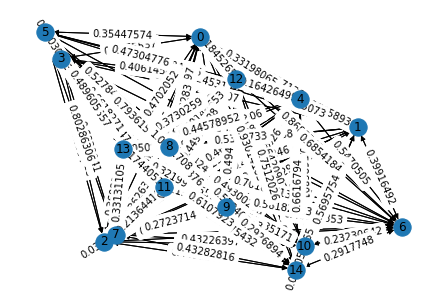

In [9]:
# 問題設定
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

CITY_NUM = 15

#generate edge
p = 1
seed = 42

g = nx.random_graphs.fast_gnp_random_graph(CITY_NUM, p, seed, directed = True)
pos = nx.random_layout(g, seed=seed)



labels = list(range(1, CITY_NUM))

#ユークリッド距離を計算し辺の重みとする
g = set_euclidean_distance(g, pos)


# edge_labels = nx.get_edge_attributes(g , 'weight')
# nx.draw(g, pos)
# nx.draw_networkx_labels(g,pos)
# nx.draw_networkx_edge_labels(g, pos  ,edge_labels=edge_labels)
draw_networkx_config(g, pos)
plt.show()

# new_g = set_tsp_graph([(0,1), (1,2), (3,2)])
# new_g = set_euclidean_distance(new_g, pos)
# draw_networkx_config(new_g, pos)
# plt.show()

# result_tsp(new_g)



In [10]:
nbs = [n for n in g.neighbors(0)]
nbs_weight = {}
for i in nbs:
    w = {i : g[0][i]['weight']}
    nbs_weight.update(w)

min_key = min(nbs_weight, key=nbs_weight.get)
print(min_key)
print(nbs_weight)


12
{1: 0.5017136, 2: 0.8242155, 3: 0.3275537, 4: 0.33198065, 5: 0.35447574, 6: 0.8688341, 7: 0.7911406, 8: 0.4317197, 9: 0.66197884, 10: 0.84521943, 11: 0.59013283, 12: 0.18452655, 13: 0.4702052, 14: 0.93014103}


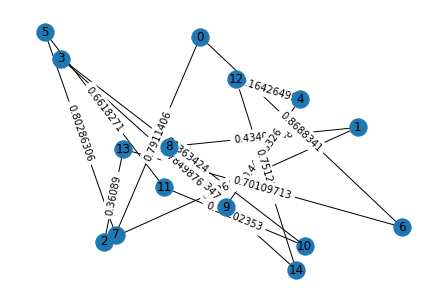

In [40]:
# random tsp  
import random

node_list  = list(g.nodes)
random_edge = []
begin_node = random.randint(0, len(node_list)-1)

first_node = begin_node
node_list.pop(first_node)

for i in range(len(node_list)):
    while True:
            index = random.randint(0, len(node_list)-1)
            if node_list[index] != first_node:
                break

    second_node =  node_list.pop(index)
    random_edge += [(first_node, second_node)]
    first_node = second_node
    
random_edge += [(begin_node, second_node)]


    
new_g = set_tsp_graph(random_edge)
new_g = set_euclidean_distance(new_g, pos)
draw_networkx_config(new_g, pos)
plt.show()

### 参考文献 
- O'REILLY Python による AIプログラミング入門
- https://qiita.com/maskot1977/items/7b64a67a6c489f47e909

---
## Q学習

### アルゴリズム
1. Q値を初期化する
2. for i = 1 to [タスクのトライアル数] do
    3. 時刻t=1として$S_0$を観測
    4. repeat
        5. 方策$π$にしたがって$a_t$を選択して行動
        6. 環境から$r_{t+1}$と$S_{t+1}$を観測
        7. Q学習の更新式に従って$Q(s_t, a_t)$の値を更新
        8. 時刻 $t ← t + 1$とする
    9. until ゴールに到達 or 終了条件に到達
10. end for

### 更新式
$Q(s_t, a) ← Q(s_t, a) + \alpha [ r_{t+1} + γ \max_p Q(s_{t+1}, p) - Q(s_t, a)]$ 

### 行動選択の方策
- greedyに最短を取り続けても，完成された閉路の巡回経路が最短とは限らない
- 隣接した都市へ移動する場合には，一般的に最短の経路を選択するのは妥当
- ランダムで他の都市を選択する

$ϵ - greedy$法を用いる

In [31]:
import random

# Q-learning 

class Agent:
    def __init__(self):
        self.Q_table = None 
        self.last_state = None
        self.last_action = None
        self.epsilon = None
        self.Graph = None
        self.reached = []
        self.path = 

    def set_state(self, state):
        self.last_state = state

    def init_Q_table(self, states_size, actions_size):
        self.Q_table = np.zeros([states_size,actions_size])
        
    def set_prameter(self, _alpha=0.1,  _gamma=0.1, _epsilon=0.1):
        self.alpha = _alpha
        self.gamma = _gamma
        self.epsilon = _epsilon
        
    def set_env(self, _Graph):
        self.Graph = _Graph



    def get_possible_reache_neighbor_list(self, Graph, state_node, reached):
        # 隣接したノードを取得
        nbs = [n for n in Graph.neighbors(state_node)]
        
        
        # 過去の通過したノードを削除
        for reached_state in reached:
            if reached_state in nbs:
                nbs.remove(reached_state)

        return nbs


    def get_min_path_state(self, Graph, state_node, nbs):

        # path weight を計算
        nbs_weight = {}
        for i in nbs:
            w = {i : Graph[state_node][i]['weight']}
            nbs_weight.update(w)

        min_state_key = min(nbs_weight, key=nbs_weight.get)
        # print(nbs_weight)

        # 最小のパスで隣接するノードを返す
        return min_state_key



    def select_action(self):
        
        pr_nbs = self.get_possible_reache_neighbor_list(self.Graph, self.last_state, self.reached)

        # 巡回路が完成しているならば行動しない
        if len(pr_nbs) == 0:
            return -1

        # epsilon - greedy 
        r = random.random()
        if r < self.epsilon:
            next_state = random.choice(pr_nbs)
        else:
            next_state = self.get_min_path_state(self.Graph, self.last_state, pr_nbs)

        # ここでは，next_stateは次へ移動すべきノードを表す．したがって，next_actionはnext_stateへ移動することを表す
        next_action = next_state

        return next_action
        
    def train(self, s, a, r, s_next):
        self.Q_table[s,a] = self.Q_table[s,a] + self.alpha * (r + self.gamma*np.max(self.Q_table[s_next,:]) - self.Q_table[s,a])


    def add_reached(self, node_name):
         self.reached += [node_name]





In [57]:
init_state = 0

agent = Agent()
agent.set_env(g)
agent.set_state( init_state )
agent.add_reached( init_state )
agent.init_Q_table(g.number_of_nodes(), g.number_of_nodes() )
agent.set_prameter(_alpha=0.5,  _gamma=0.5, _epsilon=0.3)


In [66]:

def run():
    next_a  = agent.select_action()

    if next_a == -1:
        reward = 1 / g[agent.last_state][init_state]['weight']
        agent.train(agent.last_state, init_state, reward, init_state)

        return False

    # path weight が小さいとき 報酬大
    reward = 1 / g[agent.last_state][next_a]['weight']
    agent.train(agent.last_state, next_a, reward, next_a)

    
    agent.set_state(next_a)
    agent.add_reached(next_a)
    


    return  True
    


In [70]:

while(run()):
    print(agent.Q_table)



agent.reached
pre_node = init_state
path = []
for i in range(1, len(agent.reached)):
    next_node = agent.reached[i]
    path += [(pre_node, next_node)]
    pre_node = next_node

path += [(pre_node, init_state)]




[]

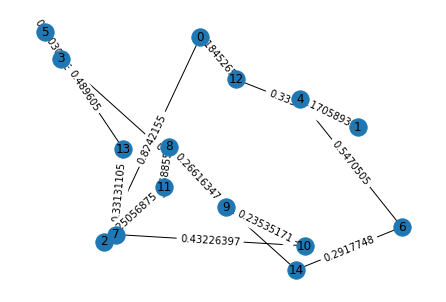

In [73]:
new_g = set_tsp_graph(path )
new_g = set_euclidean_distance(new_g, pos)
draw_networkx_config(new_g, pos)
plt.show()

In [74]:
agent.reached

[0, 12, 1, 4, 6, 14, 3, 5, 13, 7, 10, 9, 8, 11, 2]